# Amazon Fine Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review

Text - text of the review

Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

### Loading the data
The dataset is available in two forms

.csv file

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm 
import os

In [2]:
import zipfile
dataset_path = "Reviews.sqlite.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [3]:
# using sqlite3 read data
con = sqlite3.connect("database.sqlite")

# filtering only comments with score >3 and score <3 excluding reviews with score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews 
WHERE Score!=3
""",con)

# score >3 --> Positive and score <3 --> Negative
def partition(x):
    if x < 3:
        return 'negative'
    else:
        return 'positive'
    
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [4]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
filtered_data.shape

(525814, 10)

In [6]:
filtered_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
filtered_data['Score'].value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

## EDA 

Cleaning Data

At first removing duplicate values

In [8]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score!=3 AND UserId = "AR5J8UI46CURR"
ORDER BY ProductId
""",con)

In [9]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


#### Observations:
Here we can see that the ProfileName, HelpfulnessDenominator, HelpfulnessNumerator, Score, Time, Summary and Text are same.

After analysis we found that the product is same and only the flavour is different

So we will remove duplicates and keep only first value

Steps: Sort the data according to ProductId, keep first value and remove rest

In [10]:
sorted_values = filtered_data.sort_values("ProductId",axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [11]:
# now data is sorted, remove duplicate values
final = sorted_values.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

In [12]:
# checking % of data left 
(final['Id'].size*1.0/filtered_data['Id'].size*1.0)*100

69.25890143662969

In [13]:
# we also have 2 rows where HelpfulnessNumerator > HelpfulnessDenominator
# But HelpnessNumerator should be always <= HelpfulnessDenominator
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score!=3 AND Id=44737 OR Id=64422
""",con)

In [14]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [15]:
final.shape

(364173, 10)

In [16]:
# now removing above two rows 
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

## Text Preprocessing

In order to clean our text we will do following steps:

1:- Remove html tags from text

2:- Remove punctuations from text

3:- Check word is made up of alphabets only

4:- Check length of word is greater than 2

5:- Convert words to lowercase 

6:- Remove stopwords 

7:- Apply snowball stemming to the words 


In [17]:
# reviews with html tahs
import re
i = 0
for sent in final['Text'].values:
    if(len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break
    i+=1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [18]:
import re 
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop = set(stopwords.words('english')) # set of all stopwords
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[!|\'|"|?|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

print(stop)
print("**"*50)
print(sno.stem('tasty'))

{'mightn', 'll', 'm', 'ain', 'theirs', 'and', 'up', 'only', 'do', 'further', 'because', 'most', 'very', 'at', 'nor', 'yourself', 'against', 'herself', 'all', 's', "haven't", 'be', 'have', 'if', 're', 'his', 'yours', 'each', "hasn't", 'had', 'this', 'down', 'hasn', 'their', 'does', "aren't", 'doing', 'don', 'was', 'did', 'weren', 'is', 'he', 'over', 'own', 'or', 'between', 'other', 'were', 'ma', 'such', 'its', 'o', 'ourselves', "she's", 'how', 'here', "should've", 'with', 'what', 'to', 'been', 'no', 'shouldn', 'into', 'me', 'wasn', 'while', 'off', 'ours', 'himself', 'her', 'why', 'then', "shouldn't", 'about', "you'll", 'd', 'on', 'under', 'same', 'once', 'y', "don't", 'hadn', 'again', 'for', "shan't", "weren't", 'themselves', 'after', "mustn't", 'just', 'itself', 'hers', "isn't", 'i', 'our', "it's", 'aren', 'am', 'can', 'in', 'my', 'didn', 've', 'a', 'him', 'whom', 'wouldn', "wasn't", 'being', 'there', 'by', "couldn't", 'some', 'but', 'which', 'so', 'couldn', 'shan', 'when', 'who', 'tha

In [20]:
# implementing text preprocessing steps
i = 0
str1 = ''
final_string = []
all_positive_words = []
all_negative_words = []
s = ''

for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent) # remove html tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if (cleaned_words.lower() not in stop):
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if(final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    
    final_string.append(str1)
    i += 1

In [21]:
final['CleanedText'] = final_string

In [22]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [23]:
# store final table into an SQLlite table
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
final.to_sql('Reviews',conn,schema=None,if_exists='replace',index=True,index_label=None,chunksize=None,dtype=None)

In [24]:
con = sqlite3.connect('final.sqlite')

In [25]:
cleaned_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""",con)

In [26]:
cleaned_data.shape

(364171, 12)

In [27]:
# randomly sample 5k pts for both classes

data_p = cleaned_data[cleaned_data['Score'] == 'positive'].sample(n=5000)
data_n = cleaned_data[cleaned_data['Score'] == 'negative'].sample(n=5000)
final_10k = pd.concat([data_p,data_n])
final_10k.shape

(10000, 12)

In [28]:
final_10k.columns

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')

In [29]:
# sorting data based on time
final_10k['Time'] = pd.to_datetime(final_10k['Time'], unit = 's')
final_10k = final_10k.sort_values(by = 'Time')

## Bag Of Words (BOW)

In [30]:
# function to compute k 
def k_classifier_brute(X_train,y_train):
    # creating odd list of k 
    myList = list(range(0,40))
    neighbors = list(filter(lambda x: x%2 != 0 , myList))
    
    # empty list to hold cv_score
    cv_scores = []
    
    # perform k-flod cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
        scores = cross_val_score(knn, X_train,y_train, cv = 10, scoring = 'accuracy')
        cv_scores.append(scores.mean())
        
    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]
    
    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\n The optimal value of k is %d ' %optimal_k)
    
    # plot misclassification error vs k 
    plt.plot(neighbors,MSE)
    plt.title("Miscalssification Error VS K")
    plt.xlabel('Number of labels K')
    plt.ylabel("Miscalssification Erorr")
    plt.show()
    
    print("Misclassification Error: ",np.round(MSE,3))
    return optimal_k

In [31]:
# 7k data which will use to train model after vectorization
X = final_10k['CleanedText']
print('Shape of X: ', X.shape)

Shape of X:  (10000,)


In [32]:
y = final_10k['Score']
print('Shape of y: ',y.shape)

Shape of y:  (10000,)


In [33]:
# spliting data into 70% as train and 30% as test data 
from sklearn.model_selection import train_test_split

X_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)
print(X_train.shape,x_test.shape,y_train.shape,y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [34]:
# Train Vectorizer
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<7000x11526 sparse matrix of type '<class 'numpy.int64'>'
	with 225147 stored elements in Compressed Sparse Row format>

In [35]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [36]:
#Test Vectorizer
x_test = bow.transform(x_test)

In [37]:
type(x_test)

scipy.sparse.csr.csr_matrix

In [38]:
x_test.shape

(3000, 11526)


 The optimal value of k is 27 


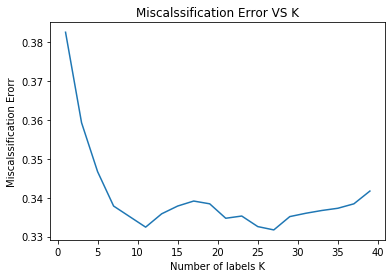

Misclassification Error:  [0.383 0.359 0.347 0.338 0.335 0.332 0.336 0.338 0.339 0.338 0.335 0.335
 0.333 0.332 0.335 0.336 0.337 0.337 0.338 0.342]


27

In [41]:
# Choose optimal k for brute force knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection 
from sklearn.model_selection import cross_validate

optimal_k_bow = k_classifier_brute(X_train,y_train)
optimal_k_bow

In [43]:
# learning model with optimal k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model 
knn_optimal.fit(X_train,y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [45]:
# Check accuracy
train_acc_bow = knn_optimal.score(X_train,y_train)
print("Train Accuracy: ",train_acc_bow)

Train Accuracy:  0.7111428571428572


In [47]:
# Error on training data
train_err_bow = 1 - train_acc_bow
print("Train Error %f%%" %(train_err_bow))

Train Error 0.288857%


In [48]:
# Evaluating accuracy on test data
acc_bow = accuracy_score(y_test,pred)*100
print("\nThe accuracy of Knn Classifier for k = %d is %f%%" %(optimal_k_bow,acc_bow))


The accuracy of Knn Classifier for k = 27 is 67.033333%


In [49]:
# confusion matric
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
cm

array([[ 680,  777],
       [ 212, 1331]], dtype=int64)

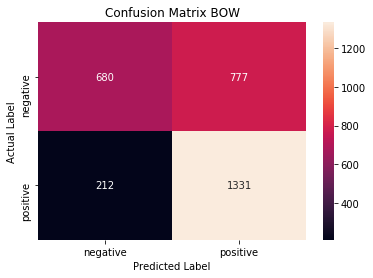

In [51]:
# plotting cm
import seaborn as sns
class_label = ['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt="d")
plt.title("Confusion Matrix BOW")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [52]:
# Classification Report 
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.76      0.47      0.58      1457
    positive       0.63      0.86      0.73      1543

    accuracy                           0.67      3000
   macro avg       0.70      0.66      0.65      3000
weighted avg       0.69      0.67      0.66      3000



#### Observations:
1:- Optimal K for our BOW model is 27

2:- After testing the model on unseeen data accuracy is 67.03% which is quite low

3:- Out of 3000 data pts it was able to predict only 2011 pts correctly.

4:- So generalixation error is high and this model won't work well 

## TF-IDF

In [53]:
final_10k.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
326,346095,374401,B00004CI84,A3M5O6UHXO9IBU,Gary,2,34,negative,2003-05-07,Certificate: Puerile,Embarrassing comedy that comes over like a chi...,b'embarrass comedi come like child attent defi...
2293,38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,positive,2003-11-04,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...,b'blend one starbuck gentler blend like tast s...


In [54]:
X = final_10k['CleanedText']
X.shape

(10000,)

In [55]:
y = final_10k['Score']
y.shape

(10000,)

In [56]:
# split data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))
X_train = tfidf_vect.fit_transform(X_train)
X_train.shape

(7000, 183200)

In [61]:
X_test = tfidf_vect.transform(X_test)
X_test.shape

(3000, 183200)


 The optimal value of k is 39 


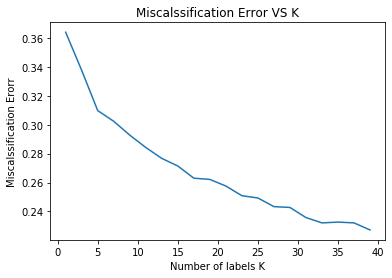

Misclassification Error:  [0.364 0.338 0.31  0.302 0.293 0.284 0.277 0.271 0.263 0.262 0.258 0.251
 0.249 0.243 0.243 0.236 0.232 0.233 0.232 0.227]


39

In [62]:
optimal_k_tfidf = k_classifier_brute(X_train,y_train)
optimal_k_tfidf

In [63]:
# model with optimal k
knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k_tfidf)

# fitting the model
knn_optimal.fit(X_train,y_train)

#predicting the response
pred = knn_optimal.predict(X_test)

In [64]:
# train accuracy
train_acc_tfidf = knn_optimal.score(X_train,y_train)
print("Training Accuracy: ",train_acc_tfidf)

Training Accuracy:  0.7988571428571428


In [65]:
# train err
train_err_tfidf = 1 - train_acc_tfidf
print("Train Error: ", train_err_tfidf)

Train Error:  0.20114285714285718


In [68]:
# Accuracy on test dataset
acc_tfidf = accuracy_score(y_test,pred)*100
print("\nTFIDF Accuacy on unseen data with k = %d is %f%%" % (optimal_k_tfidf,acc_tfidf))


TFIDF Accuacy on unseen data with k = 39 is 76.966667%


In [69]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
cm

array([[1151,  348],
       [ 343, 1158]], dtype=int64)

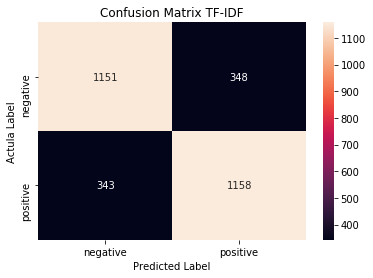

In [70]:
class_label = ["negative","positive"]
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("Actula Label")
plt.show()

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.77      0.77      0.77      1499
    positive       0.77      0.77      0.77      1501

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000



#### Observations:
1:- Optimal K for TfIdf model is 39

2:- Accuracy on unseen data is 76.96%

3:- Out of 3000pts, predicted 2309 pts correctly . So model works well.

## W2V

In [72]:
X = final_10k['Text']
X.shape

(10000,)

In [73]:
y = final_10k['Score']
y.shape

(10000,)

In [74]:
# split data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(7000,) (3000,) (7000,) (3000,)


In [77]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [78]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [79]:
w2v_model = gensim.models.Word2Vec(list_of_sent,min_count=5,size=50,workers=4)

In [80]:
w2v_model.wv.most_similar('like')

[('think', 0.7408885955810547),
 ('enjoy', 0.7337334752082825),
 ('prefer', 0.732143759727478),
 ('dislike', 0.6788761615753174),
 ('acquired', 0.6597341895103455),
 ('actually', 0.6567553281784058),
 ('awful', 0.6446927785873413),
 ('buds', 0.6427075862884521),
 ('mean', 0.6422394514083862),
 ('bitter', 0.6404612064361572)]

In [81]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\Sachin Dev\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [82]:
w2v.shape

(5335, 50)

In [87]:
# train data on test text corpus 
import gensim
list_of_sent_test = []
for sent in X_test:
    filtered_sentence =[]
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent_test.append(filtered_sentence)

In [90]:
w2v_model = gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50,workers=4)

In [91]:
w2v_model.most_similar('like')

C:\Users\Sachin Dev\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('really', 0.9560095071792603),
 ('but', 0.9484884738922119),
 ('too', 0.9308903217315674),
 ('much', 0.9141021966934204),
 ('just', 0.9011012315750122),
 ('does', 0.8992545008659363),
 ('worth', 0.8930500149726868),
 ('bad', 0.8916317820549011),
 ('how', 0.8911557197570801),
 ('sweet', 0.8902050256729126)]

In [93]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\Sachin Dev\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [94]:
w2v.shape

(3276, 50)

## AvgW2V

In [95]:
# avg word2vec
# compute avg w2v for each review
sent_vectors = []
for sent in list_of_sent:# for each review/swntence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words = 0 # num of words with valid vector in a sentence
    for word in sent: # each word in sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

7000
50


In [96]:
# avg word2vec
# compute avg w2v for each review
sent_vectors_test = []
for sent in list_of_sent_test:# for each review/swntence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words = 0 # num of words with valid vector in a sentence
    for word in sent: # each word in sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
50


In [97]:
X_train = sent_vectors

In [98]:
X_test = sent_vectors_test


 The optimal value of k is 39 


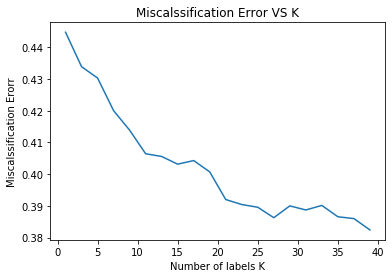

Misclassification Error:  [0.445 0.434 0.43  0.42  0.414 0.406 0.406 0.403 0.404 0.401 0.392 0.39
 0.39  0.386 0.39  0.389 0.39  0.387 0.386 0.382]


39

In [99]:
optimal_k_avgw2v = k_classifier_brute(X_train,y_train)
optimal_k_avgw2v

In [104]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(X_test)

In [105]:
# Accuracy on train data
train_acc_avgw2v = knn_optimal.score(X_train,y_train)
print("Train Accuracy: ",train_acc_avgw2v)

Train Accuracy:  0.6524285714285715


In [106]:
# Accuracy error
train_err_avgw2v = 1 - train_acc_avgw2v
print("Train Error: ", train_err_avgw2v)

Train Error:  0.34757142857142853


In [109]:
# Evaluate accuracy
acc_avgw2v = accuracy_score(y_test,pred)*100
print("\nThe accuracy of Knn on AvgW2V with k=%d is %f%%" %(optimal_k_avgw2v,acc_avgw2v))


The accuracy of Knn on AvgW2V with k=39 is 60.833333%


In [111]:
print("Test Error %f%%" %(100-(acc_avgw2v)))

Test Error 39.166667%


In [112]:
cm = confusion_matrix(y_test,pred)
cm

array([[996, 497],
       [678, 829]], dtype=int64)

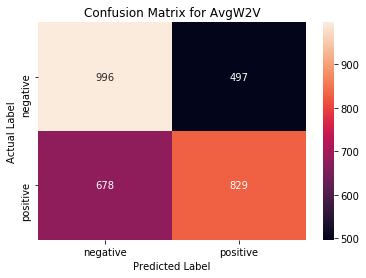

In [113]:
class_label = ["negative","positive"]
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix for AvgW2V")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [114]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.59      0.67      0.63      1493
    positive       0.63      0.55      0.59      1507

    accuracy                           0.61      3000
   macro avg       0.61      0.61      0.61      3000
weighted avg       0.61      0.61      0.61      3000



#### Observations:
1:- Optimal K = 39

2:- Out of 3000 pts 1825 classified correctly.

3: Not a good model

## Tf-Idf W2V

In [116]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

C:\Users\Sachin Dev\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [117]:
len(tfidf_sent_vectors)

7000

In [118]:
X_train = tfidf_sent_vectors

In [121]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

C:\Users\Sachin Dev\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [122]:
len(tfidf_sent_vectors_test)

3000

In [123]:
X_test = tfidf_sent_vectors_test

In [124]:
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)


 The optimal value of k is 1 


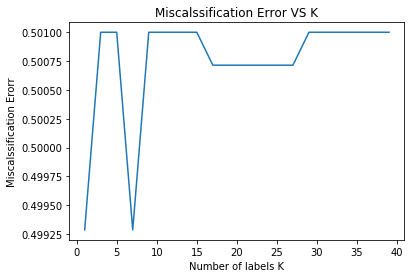

Misclassification Error:  [0.499 0.501 0.501 0.499 0.501 0.501 0.501 0.501 0.501 0.501 0.501 0.501
 0.501 0.501 0.501 0.501 0.501 0.501 0.501 0.501]


1

In [126]:
optimal_k_tfidfw2v = k_classifier_brute(X_train,y_train)
optimal_k_tfidfw2v

In [127]:
# Selecting optimal k as 4
knn_optimal = KNeighborsClassifier(n_neighbors=4)
knn_optimal.fit(X_train,y_train)
pred = knn_optimal.predict(X_test)

In [128]:
# Accuracy on train data
train_acc_tfidfw2v = knn_optimal.score(X_train,y_train)
print("Train accuracy: ",train_acc_tfidfw2v)

Train accuracy:  0.501


In [129]:
# error on train data
train_err_tfidfw2v = 1 - train_acc_tfidfw2v
print("Train error: ",train_err_tfidfw2v)

Train error:  0.499


In [137]:
# evaluate accuracy
acc_tfidfw2v = accuracy_score(y_test,pred)*100
print("\nThe accuracy of knn for k = 4 is %f%%" %(acc_tfidfw2v))


The accuracy of knn for k = 4 is 49.766667%


In [138]:
print("Test Error %f%%" %(100-(acc_tfidfw2v)))

Test Error 50.233333%


In [139]:
cm =confusion_matrix(y_test,pred)
cm

array([[1493,    0],
       [1507,    0]], dtype=int64)

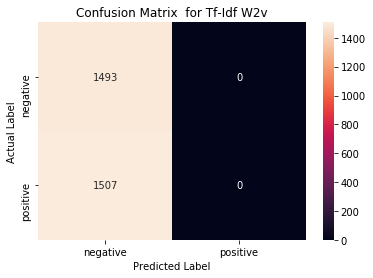

In [140]:
class_label = ["negative","positive"]
df_cm = pd.DataFrame(cm,index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = 'd')
plt.title("Confusion Matrix  for Tf-Idf W2v")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [141]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    negative       0.50      1.00      0.66      1493
    positive       0.00      0.00      0.00      1507

    accuracy                           0.50      3000
   macro avg       0.25      0.50      0.33      3000
weighted avg       0.25      0.50      0.33      3000



C:\Users\Sachin Dev\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [146]:
models = pd.DataFrame({'Model': ['KNN with Bow', "KNN with TFIDF", "KNN with Avg_w2v", "KNN with tfidf_w2v"], 
                       'Hyper Parameter(K)': [optimal_k_bow, optimal_k_tfidf, optimal_k_avgw2v, 4], 
                       'Train Error': [train_err_bow, train_err_tfidf, train_err_avgw2v, train_err_tfidfw2v], 
                       'Test Error': [100-acc_bow, 100-acc_tfidf, 100-acc_avgw2v, 100-acc_tfidfw2v], 
                       'Accuracy': [acc_bow, acc_tfidf, acc_avgw2v, acc_tfidfw2v]}, 
                      columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy
1,KNN with TFIDF,39,0.201143,23.033333,76.966667
0,KNN with Bow,27,0.288857,32.966667,67.033333
2,KNN with Avg_w2v,39,0.347571,39.166667,60.833333
3,KNN with tfidf_w2v,4,0.499000,50.233333,49.766667
